Loading the data...
Dataset shape: (284807, 31)

Data Overview:
                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481

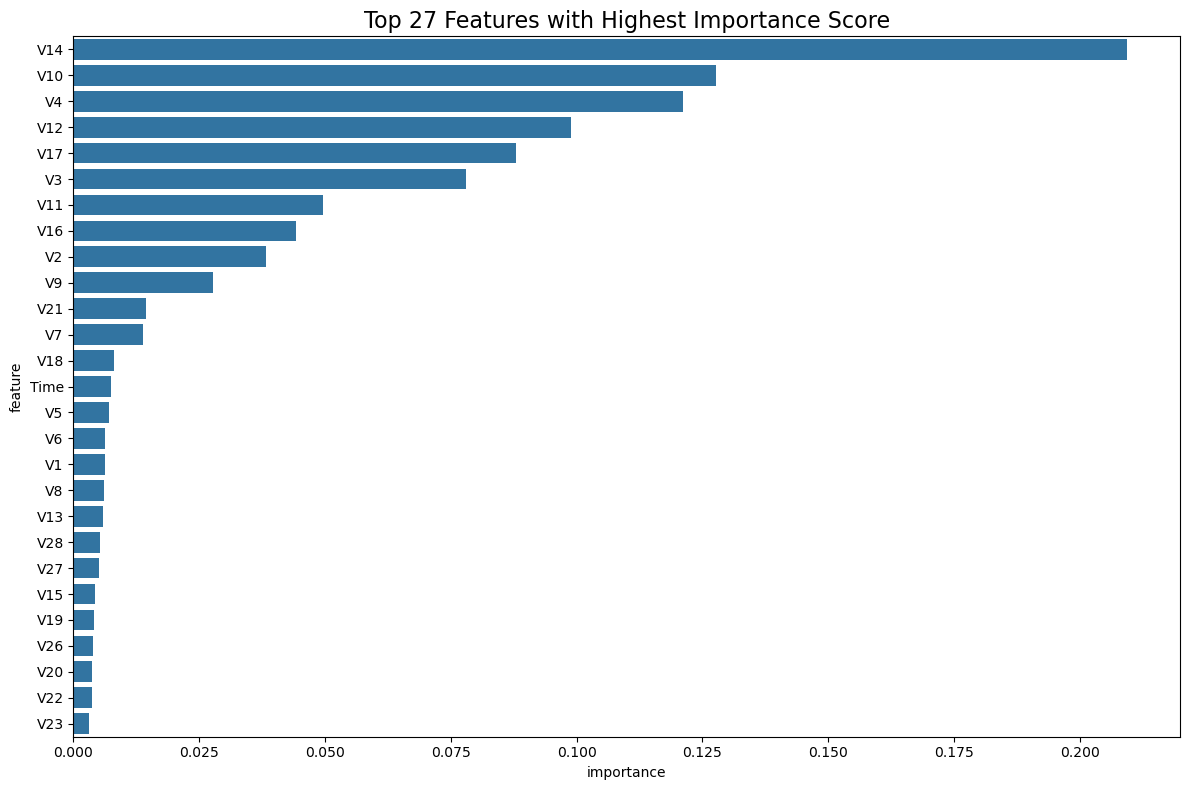


Selected 27 features for model training

Training and evaluating models...

Training LR...

Training LDA...

Training KNN...

Training CART...

Training NB...

Training RF...

Training XGB...

Training Light GBM...
[LightGBM] [Info] Number of positive: 199020, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 398040, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Model Performance on Training Data:
               KS     AUC  F1-Score  Recall   PRAUC  Precision  Accuracy
Model                                                                   
LR         0.9646  0.9985    0.9820  0.9727  0.9985     0.9915    0.9822
LDA        0.9095  0.9903    0.9318  0.8819  0.9893     0.9876    0.9354
KNN        0.

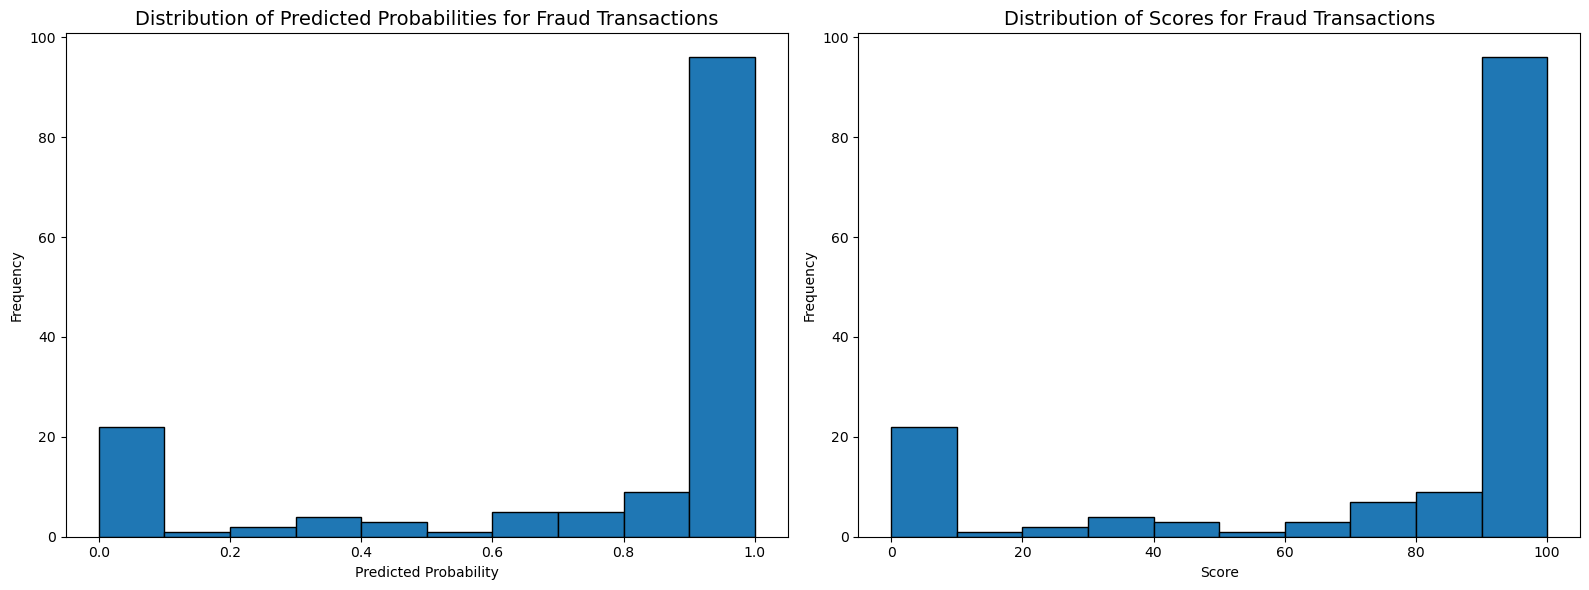


Calculating fraud detection rates by score bin...

Fraud Detection in the Test Data Set:
          probabilities  non_fraud  fraud  total  fraud_rate  cum_non_fraud  \
score_bin                                                                     
90-100          [0.9-1]          4     96    100       96.00              4   
80-89         [0.8-0.9)          2      8     10       80.00              6   
70-79         [0.7-0.8)          3      6      9       66.67              9   
60-69         [0.6-0.7)          4      5      9       55.56             13   
50-59         [0.5-0.6)          9      1     10       10.00             22   
40-49         [0.4-0.5)          9      3     12       25.00             31   
30-39         [0.3-0.4)         13      4     17       23.53             44   
20-29         [0.2-0.3)         47      1     48        2.08             91   
10-19         [0.1-0.2)        172      2    174        1.15            263   
0-9             [0-0.1)      85032     22

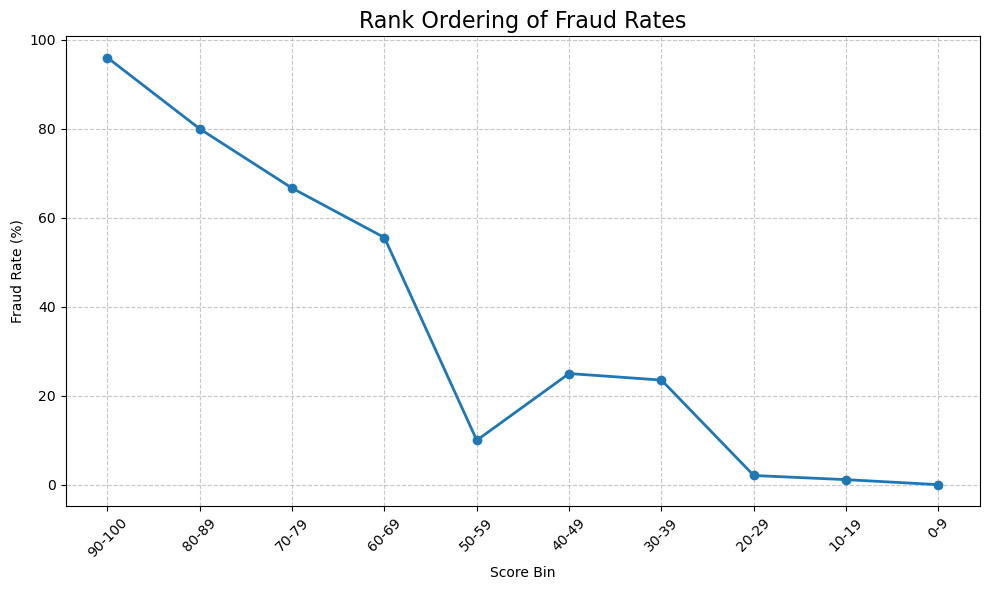

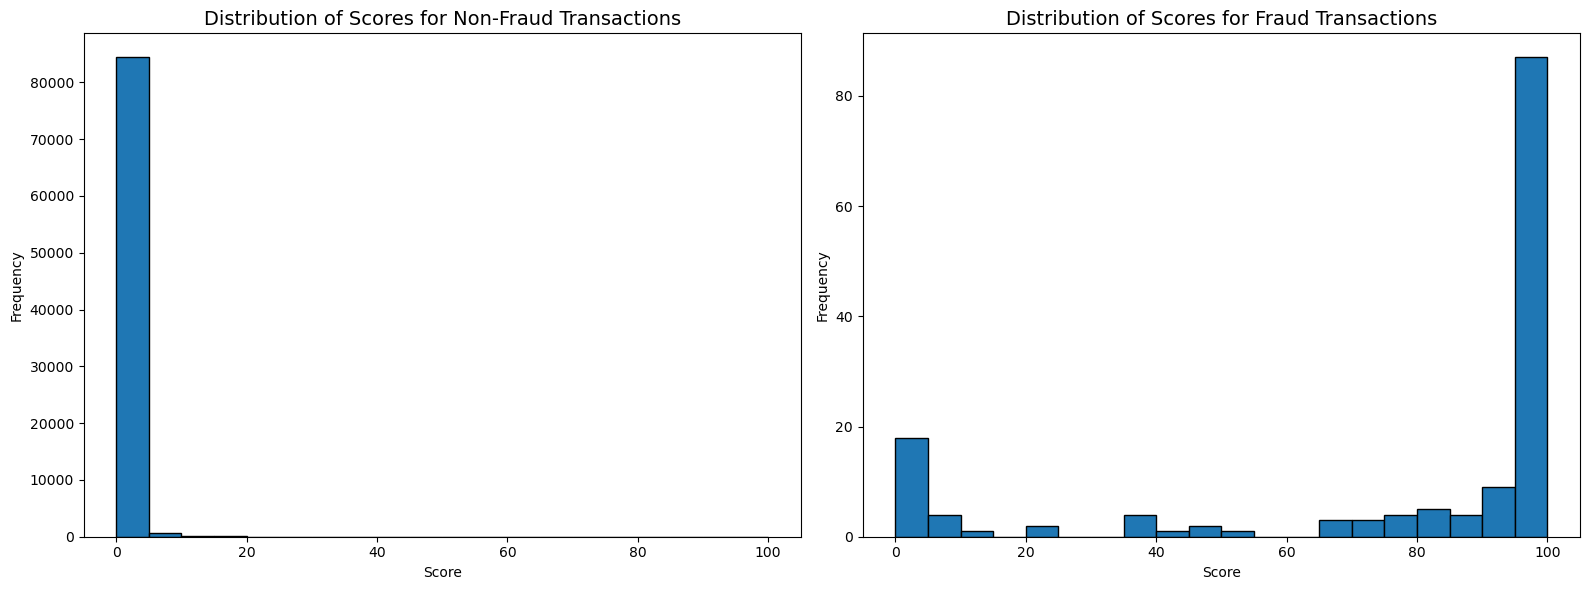

In [ ]:
# Credit Card Fraud Detection Using Machine Learning based on the paper by Benjamin Borketey

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve,
    average_precision_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
import shap
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# 1. Load the data
print("Loading the data...")
df = pd.read_csv('creditcard.csv')
print(f"Dataset shape: {df.shape}")

# 2. Data Exploration
print("\nData Overview:")
print(df.describe())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Class distribution
print("\nClass distribution:")
class_counts = df['Class'].value_counts()
print(class_counts)
print(f"Fraud percentage: {class_counts[1] / len(df) * 100:.2f}%")

# 3. Data Processing
# Feature selection will be based on correlation analysis
print("\nChecking for highly correlated features...")
correlation_matrix = df.corr().abs()
# Find features with correlation coefficient >= 0.99
high_corr_features = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if correlation_matrix.iloc[i, j] >= 0.99:
            colname = correlation_matrix.columns[i]
            high_corr_features.append(colname)
            print(f"High correlation between {correlation_matrix.columns[j]} and {colname}: {correlation_matrix.iloc[i, j]:.2f}")

# Remove highly correlated features
print(f"Removing {len(set(high_corr_features))} highly correlated features")
features_to_keep = [f for f in df.columns if f not in high_corr_features and f != 'Class']
features_to_keep.append('Class')
df = df[features_to_keep]

# Split features and target
X = df.drop('Class', axis=1)
y = df['Class']

# Split the data into training and testing sets (70-30 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Apply SMOTE to balance the training data
print("\nApplying SMOTE to balance the training data...")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Resampled training set shape: {X_train_resampled.shape}")
print(f"Class distribution after SMOTE: {pd.Series(y_train_resampled).value_counts()}")

# 4. Feature Selection using Random Forest Importance
print("\nPerforming feature selection using Random Forest importance...")
# Initialize and train a Random Forest classifier for feature selection
rf_feat_sel = RandomForestClassifier(n_estimators=100, random_state=42)
rf_feat_sel.fit(X_train_resampled, y_train_resampled)

# Get feature importances
feature_importances = pd.DataFrame({
    'feature': X_train_resampled.columns,
    'importance': rf_feat_sel.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 features by importance:")
print(feature_importances.head(10))

# Plot feature importances (as shown in Figure 1 of the paper)
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances.head(27))
plt.title('Top 27 Features with Highest Importance Score', fontsize=16)
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300)
plt.show()

# Select top 27 features as mentioned in the paper
top_features = feature_importances.head(27)['feature'].tolist()
X_train_selected = X_train_resampled[top_features]
X_test_selected = X_test[top_features]

print(f"\nSelected {len(top_features)} features for model training")

# 5. Model Building and Evaluation
# Define the models to compare
models = {
    'LR': LogisticRegression(max_iter=1000, random_state=42),
    'LDA': LinearDiscriminantAnalysis(),
    'KNN': KNeighborsClassifier(),
    'CART': DecisionTreeClassifier(random_state=42),
    'NB': GaussianNB(),
    #'SVM': SVC(probability=True, random_state=42),
    'RF': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGB': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'Light GBM': lgb.LGBMClassifier(random_state=42)
}

# Function to calculate KS statistic
def calculate_ks(y_true, y_pred_proba):
    # Sort the predictions and actual values by prediction probability
    df_ks = pd.DataFrame({
        'y_true': y_true,
        'y_pred_proba': y_pred_proba
    }).sort_values('y_pred_proba')
    
    # Calculate the cumulative distribution functions
    df_ks['cum_pos'] = df_ks['y_true'].cumsum() / df_ks['y_true'].sum()
    df_ks['cum_neg'] = (1 - df_ks['y_true']).cumsum() / (1 - df_ks['y_true']).sum()
    
    # Calculate the KS statistic
    df_ks['ks'] = df_ks['cum_pos'] - df_ks['cum_neg']
    
    # Return the maximum absolute difference
    return df_ks['ks'].abs().max()

# Train, evaluate, and store model results
print("\nTraining and evaluating models...")
train_results = pd.DataFrame(columns=['Model', 'KS', 'AUC', 'F1-Score', 'Recall', 'PRAUC', 'Precision', 'Accuracy'])
test_results = pd.DataFrame(columns=['Model', 'KS', 'AUC', 'F1-Score', 'Recall', 'PRAUC', 'Precision', 'Accuracy'])

for name, model in models.items():
    print(f"\nTraining {name}...")
    # Train the model
    model.fit(X_train_selected, y_train_resampled)
    
    # Predictions on training data
    y_train_pred = model.predict(X_train_selected)
    y_train_pred_proba = model.predict_proba(X_train_selected)[:, 1]
    
    # Calculate metrics for training data
    train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
    train_precision = precision_score(y_train_resampled, y_train_pred)
    train_recall = recall_score(y_train_resampled, y_train_pred)
    train_f1 = f1_score(y_train_resampled, y_train_pred)
    train_auc = roc_auc_score(y_train_resampled, y_train_pred_proba)
    train_prauc = average_precision_score(y_train_resampled, y_train_pred_proba)
    train_ks = calculate_ks(y_train_resampled, y_train_pred_proba)
    
    # Store training results
    train_results = pd.concat([train_results, pd.DataFrame({
        'Model': [name],
        'KS': [train_ks],
        'AUC': [train_auc],
        'F1-Score': [train_f1],
        'Recall': [train_recall],
        'PRAUC': [train_prauc],
        'Precision': [train_precision],
        'Accuracy': [train_accuracy]
    })], ignore_index=True)
    
    # Predictions on test data
    y_test_pred = model.predict(X_test_selected)
    y_test_pred_proba = model.predict_proba(X_test_selected)[:, 1]
    
    # Calculate metrics for test data
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, y_test_pred_proba)
    test_prauc = average_precision_score(y_test, y_test_pred_proba)
    test_ks = calculate_ks(y_test, y_test_pred_proba)
    
    # Store test results
    test_results = pd.concat([test_results, pd.DataFrame({
        'Model': [name],
        'KS': [test_ks],
        'AUC': [test_auc],
        'F1-Score': [test_f1],
        'Recall': [test_recall],
        'PRAUC': [test_prauc],
        'Precision': [test_precision],
        'Accuracy': [test_accuracy]
    })], ignore_index=True)

# Display training and test results (Table 1 and Table 2 in the paper)
print("\nModel Performance on Training Data:")
print(train_results.set_index('Model').round(4))

print("\nModel Performance on Test Data:")
print(test_results.set_index('Model').round(4))

# Save results to CSV
train_results.to_csv('train_results.csv', index=False)
test_results.to_csv('test_results.csv', index=False)

# 6. Calculate performance decline percentages
decline_results = pd.DataFrame(columns=['Model'])
metrics = ['KS', 'AUC', 'F1-Score', 'Recall', 'PRAUC', 'Precision', 'Accuracy']

for metric in metrics:
    decline_results[f'{metric}_Decline'] = (1 - test_results[metric] / train_results[metric]) * 100

decline_results['Model'] = train_results['Model']
print("\nPerformance Decline Percentages (Train to Test):")
print(decline_results.set_index('Model').round(2))

# Identify the best model (According to the paper, Random Forest performs best)
best_model_name = 'RF'
best_model = models[best_model_name]

# 7. Final model output and adjustment (as shown in the paper)
print(f"\nUsing {best_model_name} as the final model for real-time fraud detection")

# Generate scores for the test set (as described in the paper)
y_test_proba = best_model.predict_proba(X_test_selected)[:, 1]

# Round probabilities to 2 decimal places and multiply by 100
scores = np.round(y_test_proba, 2) * 100

# Create a new dataframe with the test data, true labels, probabilities, and scores
results_df = pd.DataFrame({
    'true_class': y_test.values,
    'probability': y_test_proba,
    'score': scores
})

# Plot the distribution of probabilities and scores for fraudulent transactions (Figure 2)
plt.figure(figsize=(16, 6))

# Plot for probabilities
plt.subplot(1, 2, 1)
fraud_probs = results_df[results_df['true_class'] == 1]['probability']
plt.hist(fraud_probs, bins=10, edgecolor='black')
plt.title('Distribution of Predicted Probabilities for Fraud Transactions', fontsize=14)
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')

# Plot for scores
plt.subplot(1, 2, 2)
fraud_scores = results_df[results_df['true_class'] == 1]['score']
plt.hist(fraud_scores, bins=10, edgecolor='black')
plt.title('Distribution of Scores for Fraud Transactions', fontsize=14)
plt.xlabel('Score')
plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig('fraud_distribution.png', dpi=300)
plt.show()

# 8. Calculate detection rate in test data (Table 3)
print("\nCalculating fraud detection rates by score bin...")

# Create score bins
results_df['score_bin'] = pd.cut(
    results_df['score'], 
    bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
    labels=['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-100'],
    include_lowest=True
)

results_df['prob_bin'] = pd.cut(
    results_df['probability'], 
    bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
    labels=['[0-0.1)', '[0.1-0.2)', '[0.2-0.3)', '[0.3-0.4)', '[0.4-0.5)', '[0.5-0.6)', '[0.6-0.7)', '[0.7-0.8)', '[0.8-0.9)', '[0.9-1]'],
    include_lowest=True
)

# Reverse the order for displaying from highest to lowest
detection_rate_df = results_df.groupby('score_bin').agg(
    non_fraud=('true_class', lambda x: (x == 0).sum()),
    fraud=('true_class', lambda x: (x == 1).sum())
).sort_index(ascending=False)

detection_rate_df['total'] = detection_rate_df['non_fraud'] + detection_rate_df['fraud']
detection_rate_df['fraud_rate'] = detection_rate_df['fraud'] / detection_rate_df['total'] * 100

# Calculate cumulative counts and detection rate
detection_rate_df['cum_non_fraud'] = detection_rate_df['non_fraud'].cumsum()
detection_rate_df['cum_fraud'] = detection_rate_df['fraud'].cumsum()
detection_rate_df['det_rate'] = detection_rate_df['cum_fraud'] / detection_rate_df['fraud'].sum() * 100
detection_rate_df['fpr'] = detection_rate_df['cum_non_fraud'] / detection_rate_df['non_fraud'].sum()

# Create a mapping of score bins to probability bins for display
prob_mapping = {
    '90-100': '[0.9-1]',
    '80-89': '[0.8-0.9)',
    '70-79': '[0.7-0.8)',
    '60-69': '[0.6-0.7)',
    '50-59': '[0.5-0.6)',
    '40-49': '[0.4-0.5)',
    '30-39': '[0.3-0.4)',
    '20-29': '[0.2-0.3)',
    '10-19': '[0.1-0.2)',
    '0-9': '[0-0.1)'
}

# Create a DataFrame with the probability bins
detection_rate_display = detection_rate_df.copy()
detection_rate_display.insert(0, 'probabilities', detection_rate_display.index.map(prob_mapping))

# Format the output to match Table 3 in the paper
print("\nFraud Detection in the Test Data Set:")
print(detection_rate_display.round(2))

# Save the detection rate table
detection_rate_display.to_csv('detection_rate.csv')

# 9. Plot rank ordering / monotonicity (Figure 3)
plt.figure(figsize=(10, 6))
plt.plot(detection_rate_df.index, detection_rate_df['fraud_rate'], marker='o', linewidth=2)
plt.title('Rank Ordering of Fraud Rates', fontsize=16)
plt.xlabel('Score Bin')
plt.ylabel('Fraud Rate (%)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('rank_ordering.png', dpi=300)
plt.show()

# 10. Plot distribution of scores by fraud tag (Figure 4)
plt.figure(figsize=(16, 6))

# Plot for non-fraud transactions
plt.subplot(1, 2, 1)
non_fraud_scores = results_df[results_df['true_class'] == 0]['score']
plt.hist(non_fraud_scores, bins=20, edgecolor='black')
plt.title('Distribution of Scores for Non-Fraud Transactions', fontsize=14)
plt.xlabel('Score')
plt.ylabel('Frequency')

# Plot for fraud transactions
plt.subplot(1, 2, 2)
fraud_scores = results_df[results_df['true_class'] == 1]['score']
plt.hist(fraud_scores, bins=20, edgecolor='black')
plt.title('Distribution of Scores for Fraud Transactions', fontsize=14)
plt.xlabel('Score')
plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig('score_distribution_by_class.png', dpi=300)
plt.show()